In [1]:
##### Importando Bibliotecas: #####
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import statsmodels.api as sm
from random import randint
import pandas as pd
import numpy as np
import itertools
import requests
import math
import os
import re

from scipy import stats
from sklearn.neighbors import KNeighborsRegressor



######## Funções: ########

#Método dos Mínimos Quadrados: (Já testada e funfando)
def mmq(lX,lY):
    mediaX, mediaY = np.mean(lX), np.mean(lY)

    Sxx, Sxy = 0, 0
    for num in range(len(lX)):
        deltaX, deltaY = (lX[num] - mediaX), (lY[num] - mediaY)
        Sxx += deltaX **2
        Sxy += deltaX * deltaY

        b1 = Sxy/Sxx
        b0 = mediaY - b1*mediaX

    return [b0,b1]

def yPrevReta(varX, varY):
    [b0,b1] = mmq(varX,varY)

    Ycalc = []
    for xi in list(varX):
        yi_calc = b0 + b1*xi
        Ycalc.append(yi_calc)
    return Ycalc

#Recebe uma URL e retorna o código HTML da página (Só é chamada pela função baixarBD)
def baixarhtml(url):
    html = requests.get(url).text.splitlines()
    return html

def regressao(lX,lY):
    Xreg = sm.add_constant(lX)
    model = sm.OLS(lY,Xreg)
    results = model.fit()
    return results

___
# Ciência dos Dados - PROJETO 3 - INSPER

___
### Mariana Abrantes, Gabriel Couto e Gabriel Miras
___

# Previsão do preço do Iphone X através do preço do dolar e de outros 7 smartphones do mercado

___

## A. INTRODUÇÃO

Nestes últimos anos, com a instabilidade política e socioeconômica do Brasil, o preço do dólar está em constante variação. Consequentemente, os valores sobre produtos estrangeiros também mudam. Além disso, o preço de outros dispositivos do mercado podem influenciar o preço de um produto. Ao visualizar esse cenário, gostaríamos de analisar a influência da alteração do valor do dólar, de 3 aparelhos da Apple e de 4 aparelhos da Samsung sobre o preço do Iphone X.

Escolhemos criar modelos preditivos usando 7 modelos de smarthphones disponíveis no mercado e o preço do dólar para fazermos previsões a cerca do preço do Iphone X.<br>
<br>
__Variável Dependente (resposta) - Y : Preço do Iphone X__ (Váriavel de interesse cujo comportamento se deseja explicar)<br>
__Variável Independente (explicativa) - X: Dolar e o preço dos outros celulares__ (Usadas para explicar Y)<br>

___
## B. MINERANDO DADOS e CARACTERÍSTICAS DO DATASET

___
### B.1) Minerando Dados

__I) Preço do Dólar__ <br>
&emsp;O DataFrame foi obtido no [site](https://economia.uol.com.br/cotacoes/cambio/dolar-comercial-estados-unidos/) e foi filtrado da seguinte forma:
 * a) Definimos a coluna 'Data' como índice da tabela
 * b) Pegamos apenas a coluna 'Compra' com o preço do dolar no dia e o índice das linhas
 * c) Definimos a coluna 'Compra' do tipo float e renomeamos ela pra "Dolar"

In [2]:
dolar = pd.read_table("dolar.csv", sep=";", usecols=['Data','Compra'])
dolar['Data'] = pd.to_datetime(dolar['Data'],  format='%d/%m/%Y %H:%M:%S')
dolar.index = dolar['Data']
dolar['Dolar'] = dolar['Compra'].astype('float')
dolar = dolar.loc[:,['Dolar']]

__II) Tabela de Preços dos Smartphones__ <br>
Os dados de cada celular foram retirados do histórico de preço médio do site buscape. <br>
* a) A função gerarBD() recebe uma lista com nome e url do celular para retornar um Dataframe de preço dos celulares e do dolar por dia.<br>
Para cada linha da lista:
    * 1) Cria uma cópia do Dataframe dolar chamado table
    * 2) Baixa o código da url fornecida e captura o ID do produto
    * 3) Com o ID baixamos o histórico de preço médio do aparelho em JSON e criamos o Dataframe bd com ele
    * 4) Usamos .join para unir as colunas num novo dataframe
    * 5) Definimos a coluna 'Data' como do tipo datetime e em seguida definimos essa coluna como índice da tabela<br>
* b) Removemos as linhas que possuam ao menos um valor vazio e retornamos essa nova tabela como resultado da função

In [3]:
#Recebe url do Buscape e retorna um Dataframe 
def gerarBD(lista):
    table = dolar.copy()
    
    for num in range(len(lista)):
        produto, url = lista[num][0], lista[num][1]
        
        #Pega ID do produto do buscape usando a url fornecida
        code = baixarhtml(url)
        for num_linha in range(len(code)):
            match = re.findall('"productId":[0-9]*', code[num_linha])
            if len(match)>0:
                id = match[0].split(':')[1]

        #Baixa BD dos preços
        code = baixarhtml("https://www.buscape.com.br/async/history/idu/" + id + "/days/365")

        #Pega só a parte dos dados e cria tabela bd
        bd = pd.read_json(code[0].split('"historicos":')[1][:-1])

        #Converte data pro formato e define essa coluna como índice
        bd['data'] = pd.to_datetime(bd['data'],  format='%d/%m/%Y')
        bd.set_index(bd['data'], inplace=True)
        
        #Adiciona a coluna com o nome do produto o preço do produto
        table[produto] = bd.loc[:,['precomed']]
        table[produto] = table[produto].astype(float)
    
    table = table.dropna(how='any') # Tira linha que tiver algum valor NaN
    return table

#Função retorno
def func_retorno(n,n_ant):
    val = 0
    if n_ant == 0:
        print('tem zero')
    else:
        val = math.log(n/n_ant)
    return val

In [4]:
links = [
    ['Iphone X',          "https://www.buscape.com.br/smartphone-apple-iphone-x-64gb"],
    ['Iphone 8 Plus',     "https://www.buscape.com.br/smartphone-apple-iphone-8-plus-64gb"],
    ['Iphone 7',          "https://www.buscape.com.br/smartphone-apple-iphone-7-32gb"],
    ['Iphone 7 Plus',     "https://www.buscape.com.br/smartphone-apple-iphone-7-plus-128gb"],
    ['Galaxy S8',         "https://www.buscape.com.br/smartphone-samsung-galaxy-s8-sm-g950-64gb"],
    ['Galaxy S8 Plus',    "https://www.buscape.com.br/smartphone-samsung-galaxy-s8-plus-sm-g955-128gb"],
    ['Galaxy S9',         "https://www.buscape.com.br/smartphone-samsung-galaxy-s9-sm-g960-128gb"],
    ['Galaxy S9 Plus',    "https://www.buscape.com.br/smartphone-samsung-galaxy-s9-plus-sm-g965-128gb"]
]

___
### B.2) Características do Dataset

O dataset consiste de ...

___
__Salvando os dados para não precisar criar um dataframe a cada execução do código__<br>
Se não houver o arquivo tabela.csv na pasta executa a função gerarBD() e salva o dataframe como tabela.csv, se já houver o arquivo tabela.csv carrega ele como tabela.

In [5]:
#Se já tiver um arquivo tabela.csv salvo carrega ele, se não cria a tabela e salva ela
exists = os.path.isfile('tabela.csv')
if exists:
    tabela = pd.read_csv('tabela.csv', sep=",")
    tabela.index = tabela['data']
    tabela = tabela.loc[:,list(tabela.columns)[1:]]
else:
    tabela = gerarBD(links)
    tabela.to_csv('tabela.csv')

### BASE DE DADOS

__I)Tabela com todos dados que serão usados:__<br>

In [6]:
tabela.head(3)

,Iphone X,Iphone 8 Plus,Iphone 7,Iphone 7 Plus,Galaxy S8,Galaxy S8 Plus,Galaxy S9,Galaxy S9 Plus,Dolar
data,,,,,,,,,
2018-05-22,5791.4575,4019.5854,3033.4468,3491.2202,3050.4950,4085.785,3956.2925,4479.7305,3.6447
2018-05-23,5853.7800,4057.0140,3043.2737,3406.8965,3061.1514,3672.570,3966.1755,4490.3880,3.6251
2018-05-24,5885.4900,3896.7625,2852.5547,3444.2380,2992.7668,4028.438,3966.7402,4502.2856,3.6483


__II) Criando tabela de retorno__ <br>

In [7]:
df = tabela.copy()

#Cria coluna com o valor da linha anterior
for coluna in tabela.columns:
    df[coluna+'-1'] = df[coluna].shift(1)

df = df.iloc[1:,:] # Tira primeira linha (perdida pra fazer deltas)

dic={}
for coluna in tabela.columns:
    lis,ind=[],[]
    for index, row in df.iterrows():
        retor = func_retorno(row[coluna],row[coluna+'-1'])
        lis.append(retor)
        ind.append(index)
    dic[coluna]=lis

retorno = pd.DataFrame(data=dic,index=ind)

In [8]:
retorno.head(3)

,Iphone X,Iphone 8 Plus,Iphone 7,Iphone 7 Plus,Galaxy S8,Galaxy S8 Plus,Galaxy S9,Galaxy S9 Plus,Dolar
2018-05-23,0.010704,0.009268,0.003234,-0.024450,0.003487,-0.106622,0.002495,0.002376,-0.005392
2018-05-24,0.005402,-0.040301,-0.064719,0.010901,-0.022593,0.092487,0.000142,0.002646,0.006379
2018-05-25,-0.001517,0.031066,0.045622,0.007526,0.044937,-0.088895,0.010331,-0.007334,0.005467


__III) Separando a tabela em teste e treinamento__

In [9]:
percentTreino = 0.8 #Proporção entre o comprimento do treinamento o dataframe dados.

treino = retorno.sample(frac=percentTreino,random_state=randint(0,100000))
teste = retorno.drop(treino.index)

print('Comprimento Teste: '+str(len(teste))+' | Comprimento Treino: '+str(len(treino)))

Comprimento Teste: 49 | Comprimento Treino: 195


Definindo algumas variáveis que serão usadas:

In [10]:
# colRes = Coluna Resposta (Dependente)
colRes = 'Iphone X'

# colExp = Lista de Colunas Explicativas (Independentes)
colExp = list(treino.columns)
colExp.remove(colRes)

# dataframe Resposta 
dfRes = treino.loc[:,[colRes]]

# dataframe variáveis Explicativas (Dataframe)
dfExp = treino.loc[:,colExp]

### ANÁLISE DESCRITIVA

Em nossa base de dados buscamos os preços de telefones das marcas Apple e Samsung, sendo eles Iphone X, Iphone 8 Plus, Iphone 7 plus, iphone 7, Galaxy S8, Galaxy S8 Plus, Galaxy S9 e Galaxy S9 Plus.

In [11]:
#Correlação
treino.corr()

,Iphone X,Iphone 8 Plus,Iphone 7,Iphone 7 Plus,Galaxy S8,Galaxy S8 Plus,Galaxy S9,Galaxy S9 Plus,Dolar
Iphone X,1.000000,0.038458,0.135383,0.145399,0.041410,0.063409,0.154666,0.105938,-0.043812
Iphone 8 Plus,0.038458,1.000000,0.091675,0.177954,0.034680,0.039714,0.023200,-0.093862,-0.089082
Iphone 7,0.135383,0.091675,1.000000,0.451567,-0.114831,0.015241,-0.054389,-0.075561,-0.090650
Iphone 7 Plus,0.145399,0.177954,0.451567,1.000000,0.008723,-0.005675,-0.027251,-0.037612,0.053955
Galaxy S8,0.041410,0.034680,-0.114831,0.008723,1.000000,-0.031697,0.086225,0.091342,-0.084005
Galaxy S8 Plus,0.063409,0.039714,0.015241,-0.005675,-0.031697,1.000000,-0.170571,-0.091199,-0.102366
Galaxy S9,0.154666,0.023200,-0.054389,-0.027251,0.086225,-0.170571,1.000000,0.335653,0.063197
Galaxy S9 Plus,0.105938,-0.093862,-0.075561,-0.037612,0.091342,-0.091199,0.335653,1.000000,0.025592
Dolar,-0.043812,-0.089082,-0.090650,0.053955,-0.084005,-0.102366,0.063197,0.025592,1.000000


# Descriçao analise 

In [12]:
treino.describe()

,Iphone X,Iphone 8 Plus,Iphone 7,Iphone 7 Plus,Galaxy S8,Galaxy S8 Plus,Galaxy S9,Galaxy S9 Plus,Dolar
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,-0.001356,0.000066,0.000528,0.001785,-0.000947,0.000480,-0.001538,-0.002050,0.000430
std,0.028398,0.034559,0.037140,0.038844,0.031220,0.034597,0.042244,0.035661,0.010465
min,-0.105792,-0.124957,-0.151601,-0.155254,-0.125202,-0.220123,-0.122101,-0.113739,-0.057482
25%,-0.010199,-0.018857,-0.016521,-0.007636,-0.013992,0.000000,-0.021692,-0.022438,-0.005790
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000763
75%,0.008107,0.013090,0.015520,0.011576,0.005859,0.000000,0.016930,0.014578,0.006892
max,0.139597,0.116284,0.115890,0.155254,0.142910,0.232399,0.149577,0.112801,0.026513


__I) Análise Univariada:__ <br>

Histograma das variáveis:

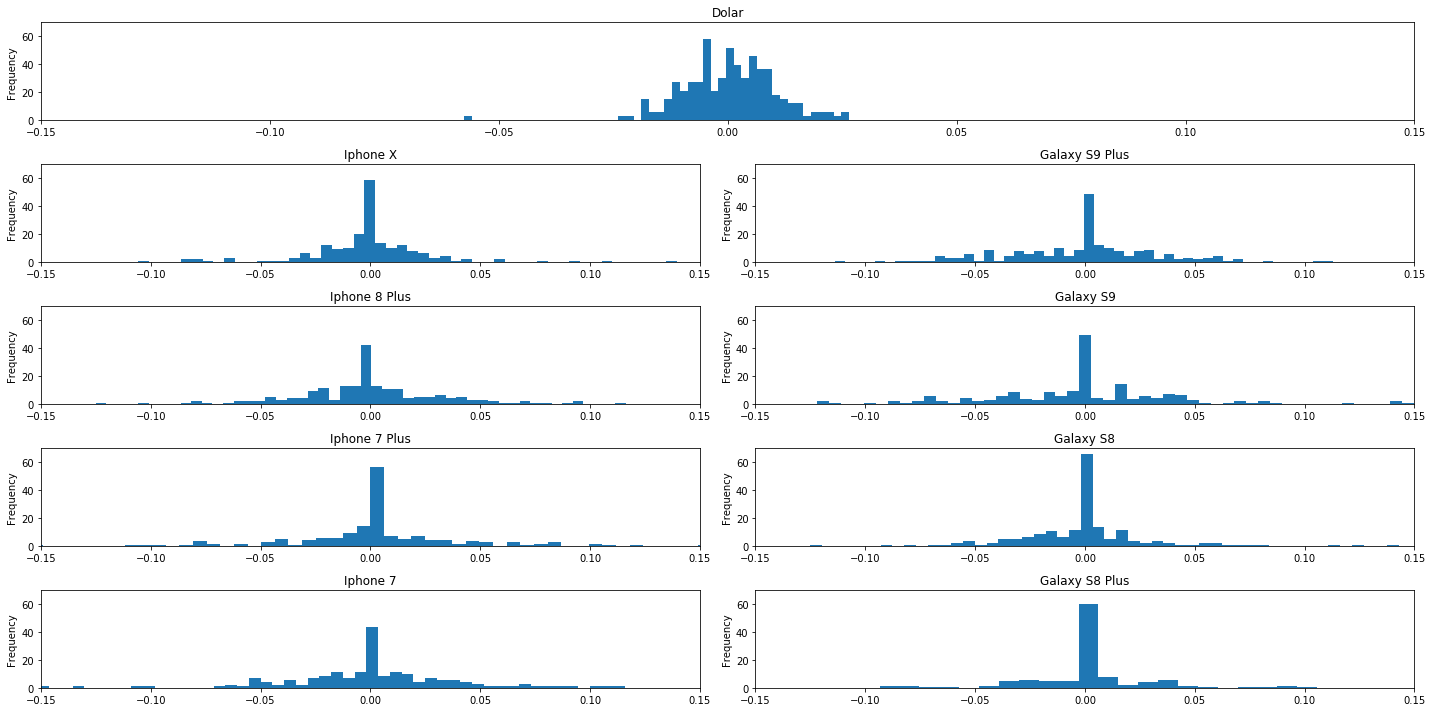

In [13]:
#Limites do gráfico:
xlim, ylim = [-0.15,0.15], [0,70] 

#Dita a ordem que os grpaficos vão aparecer
labels0 = ['Iphone X','Iphone 8 Plus','Iphone 7 Plus','Iphone 7']
labels1 = ['Galaxy S9 Plus', 'Galaxy S9', 'Galaxy S8', 'Galaxy S8 Plus']

fig = plt.figure(figsize=(20,10)) #largura da linha,altura da linha

#Dolar
plt.subplot2grid((5, 2), (0, 0), colspan=2)
plt.xlim(xlim[0],xlim[1])
plt.ylim(ylim[0],ylim[1])
treino['Dolar'].plot.hist(bins=50, title='Dolar', density=True);        

#Outras colunas
for n_y in [0,1]:
    if n_y == 0:
        labels = labels0
    if n_y == 1:
        labels = labels1
        
    for n_x in [1,2,3,4]:
        ax = plt.subplot2grid((5, 2), (n_x, n_y))
        plt.xlim(xlim[0],xlim[1])
        plt.ylim(ylim[0],ylim[1])
        treino[labels[n_x-1]].plot.hist(bins=50, title=labels[n_x-1], density=True);        
        
plt.tight_layout()
plt.show()

___
## C. MODELOS DE PREDIÇÃO

* __Modelo de Predição pela Média (Sem uso de variável explicativa).__ <br>
Consiste em usarmos como equação matemática do modelo a reta $y(t) = \mu$, sendo $\mu$ a média aritmética dos valores da variável resposta. (y(t) será uma reta paralela ao eixo x).

In [25]:
yPrevReta([0,1], [0,1])

[0.0, 1.0]

In [26]:
x_1 = sm.add_constant(dfRes) #Adiciona uma coluna de com 1 tabela com a variável X
y_1 = [np.mean(dfRes)] * len(treino) #lista com o mesmo nº de média que o comprimento do treino

model = sm.OLS(y_1,x_1)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                      -8.000
Model:                            OLS   Adj. R-squared:                 -8.047
Method:                 Least Squares   F-statistic:                    -171.6
Date:                Sat, 25 May 2019   Prob (F-statistic):               1.00
Time:                        03:28:51   Log-Likelihood:                 7889.2
No. Observations:                 195   AIC:                        -1.577e+04
Df Residuals:                     193   BIC:                        -1.577e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0014   4.69e-20  -2.89e+16      0.000      -0.001      -0.001
Iphone X    4.337e-19   1.65e-18      0.262      0.793   -2.83e-18    3.69e-18
==============================================================================
Omnibus:                        1.026   Durbin-Watson:                   0.000
Prob(Omnibus):                  0.599   Jarque-Bera (JB):               73.125
Skew:                           0.000   Prob(JB):                     1.32e-16
Kurtosis:                       0.000   Cond. No.                         35.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

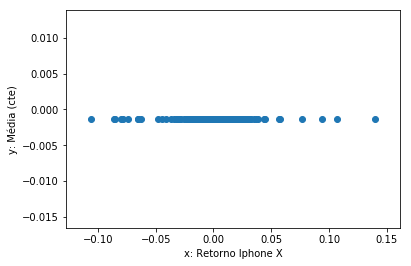

In [27]:
plt.scatter(dfRes,y_1);
plt.xlabel("x: Retorno Iphone X");
plt.ylabel("y: Média (cte)");

* __Modelo de Regressão Linear Múltipla (Multiple Linear Regression)__<br>
$$\hat{y}(t)=\beta_{0}+ \beta_{1}x_{1}+ \beta_{2}x_{2} + \cdots + \beta_{8}x_{8}+ \epsilon_{i}$$
Em que $\beta_{i}$ é o coeficiente, $\epsilon_{i}$ é o erro aleatório da medida i, $\hat{y}(t)$ é o valor de y previsto no 'instante' i.

In [28]:
listaRMS=[]
for coluna in colExp:
    rms = mmq(treino[coluna], dfRes[colRes])
    listaRMS.append(rms)

In [29]:
regressao(dfExp,dfRes).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Iphone X   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     1.744
Date:                Sat, 25 May 2019   Prob (F-statistic):             0.0907
Time:                        03:29:02   Log-Likelihood:                 425.34
No. Observations:                 195   AIC:                            -832.7
Df Residuals:                     186   BIC:                            -803.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0012      0.002     -0.609      0.544      -0.005       0.003
Iphone 8 Plus      0.0041      0.060      0.068      0.946      -0.114       0.122
Iphone 7           0.0748      0.062      1.209      0.228      -0.047       0.197
Iphone 7 Plus      0.0802      0.059      1.353      0.178      -0.037       0.197
Galaxy S8          0.0283      0.066      0.431      0.667      -0.101       0.158
Galaxy S8 Plus     0.0756      0.059      1.276      0.203      -0.041       0.193
Galaxy S9          0.1035      0.051      2.017      0.045       0.002       0.205
Galaxy S9 Plus     0.0580      0.060      0.960      0.338      -0.061       0.177
Dolar             -0.1085      0.197     -0.550      0.583      -0.497       0.280
==============================================================================
Omnibus:                       29.159   Durbin-Watson:                   2.105
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              188.437
Skew:                           0.152   Prob(JB):                     1.21e-41
Kurtosis:                       7.806   Cond. No.                         98.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [30]:
yPrevisto=[]
for index, row in dfExp.iterrows():
    yprev=0
    for i in range(len(colExp)):
        yprev += listaRMS[i]*row[colExp[i]]
    yPrevisto.append(yprev)

mmq(yPrevisto, dfRes)

TypeError: can't multiply sequence by non-int of type 'numpy.float64'

In [ ]:
regressao(yPrevisto,dfRes).summary()

o MODELO DOS K VIZINHOS MAIS PRÓXIMOS (K-Nearest Neighbors Regression)

In [ ]:
# X=tabela['Dolar']
# y=tabela.loc[:,['Iphone 7','Iphone 7 Plus','Iphone X', 'Iphone 8 Plus', 'Galaxy S8', 'Galaxy S8 Plus', 'Galaxy S9', 'Galaxy S9 Plus']]
# X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=.3,random_state=0)

In [ ]:
# clf=KNeighborsRegressor(1)
# clf.fit(X_train,y_train)
# y_pred=clf.predict(X_test)
# print(mean_squared_error(y_test,y_pred))

o MODELO DE REGRESSÃO LINEAR (Multiple Linear Regression)

In [ ]:
x = retorno['Dolar']
xb = x.mean()
x_v = np.linspace(x.min(), x.max(), 500)


def Regressao():
    betas = []
    valoresY = []
    
    for i in retorno.columns[:-1]:
        y = retorno[i]

        #beta^0 e beta^1
        yb = y.mean()


        Sxy = ((x -xb)*(y -yb)).sum()
        Sxx = ((x -xb)**2).sum()

        b1 = Sxy/Sxx
        b0 = yb - b1*xb
        betas.append([b0, b1])
        
        y_v = b0 + b1*x_v
        valoresY.append(y_v)
        
    return [betas, valoresY]
    
#print(Regressao()[0]) ---> valores beta
#len(Regressao()[1]) #---> valores Y

In [ ]:
x = dfRes


xb = x.mean()
x_v = np.linspace(x.min(), x.max(), 500)


def Regressao():
    for i in retorno.columns[:-1]:
        y = retorno[i]

        #beta^0 e beta^1
        yb = y.mean()


        Sxy = ((x -xb)*(y -yb)).sum()
        Sxx = ((x -xb)**2).sum()

        b1 = Sxy/Sxx
        b0 = yb - b1*xb
        betas.append([b0, b1])
        
        y_v = b0 + b1*x_v
        valoresY.append(y_v)
        
    return 
    
#print(Regressao()[0]) ---> valores beta
#len(Regressao()[1]) #---> valores Y

In [ ]:
x = retorno['Dolar']
xb = x.mean()
x_v = np.linspace(x.min(), x.max(), 500)


def reg(dataf):
    betas = []
    valoresY = []
    
    for i in dataf.columns[:-1]:
        y = retorno[i]

        #beta^0 e beta^1
        yb = y.mean()


        Sxy = ((x -xb)*(y -yb)).sum()
        Sxx = ((x -xb)**2).sum()

        b1 = Sxy/Sxx
        b0 = yb - b1*xb
        betas.append([b0, b1])
        
        y_v = b0 + b1*x_v
        valoresY.append(y_v)
        
    return [betas, valoresY]
    
#print(Regressao()[0]) ---> valores beta
#len(Regressao()[1]) #---> valores Y

In [ ]:
valoresY = Regressao()[1]
for i in range(len(retorno.columns[:-1])):
    plt.plot(x_v,valoresY[i], color="r") # resultados da regressão
    plt.scatter(x, y); # dados
    plt.xlabel("x: dolar");
    plt.ylabel("y: celular");
    plt.show() #informar os nomes de celular em cada grafico

In [ ]:
e = y - (b0 + b1*x) # Escreva sua fórmula dos resíduos aqui

stats.probplot(e, dist='norm', plot=plt); # Verifique graficamente  se é uma normal - como fazer isso?

o MODELO DE ÁRVORES DE REGRESSÃO (Decision Tree Regression)

___
## D. PROCESSO E ESTATÍSTICAS DE VALIDAÇÃO

[Esse item depende dos resultados das modelagens anteriores! Organize-os aqui de forma clara!]

___
## E. CONCLUSÃO

___
## F. REFERÊNCIAS BIBLIOGRÁFICAS

https://br.investing.com/ $\rightarrow$ site para busca da cotação dos dolores
_________
https://www.buscape.com.br $\rightarrow$ site para busca de histórico dos preços